In [1]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Multi-series forecasting

https://www.cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html

https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/multivariate-forecasting.html

### Import libraries

In [2]:
# Modules
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Autoregressor
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate

# Hyperparameter Grid search
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

# Backtesting
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler

import plotly.io as pio

In [3]:
import sktime
from sktime.utils.plotting import plot_series

In [4]:
# Enable to render plotly graphs into GitHub
#pio.renderers.default = "svg"

In [5]:
dep_var = 'FIN' # Do not change
country = 'ALL' # Do not change

# Select Orders or TIV
target = "TIV" 

### Load Data

In [6]:
# Input path and filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + 'target.xlsx'

df = pd.read_excel(file, sheet_name=target)

# Set index
df = df.set_index("Date").asfreq('MS')

In [7]:
df

,FIN,DEN,NOR,SWE
Date,,,,
2006-01-01,203.413007,65.640787,64.899178,63.568847
2006-02-01,128.084250,61.924395,64.653451,67.391665
2006-03-01,151.605878,83.479473,84.919086,92.858327
2006-04-01,135.086704,77.672609,73.288018,95.325089
2006-05-01,166.978193,91.928459,90.939393,107.940718
...,...,...,...,...
2022-08-01,78.449535,74.473027,94.243053,71.260900
2022-09-01,74.997932,75.796992,109.443986,76.413249
2022-10-01,68.348358,63.242553,94.714030,76.986837


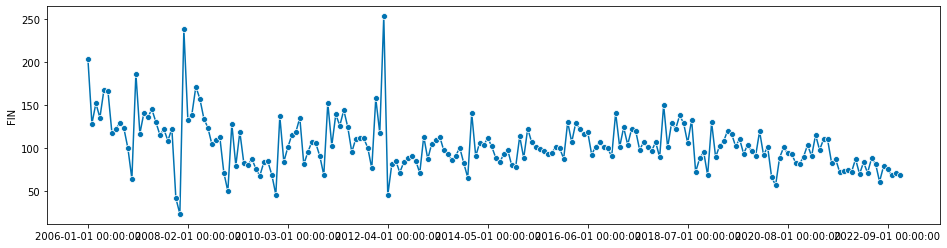

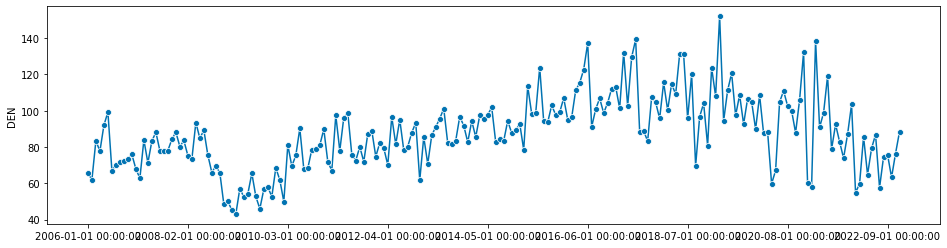

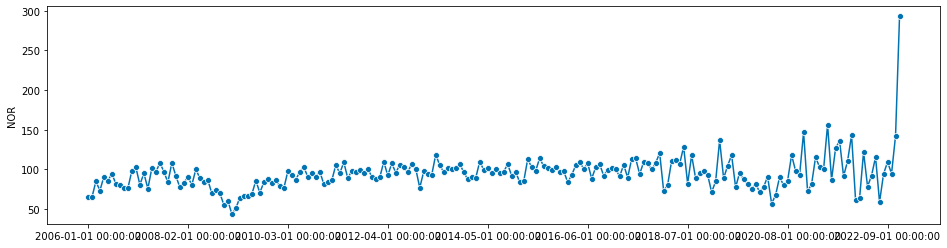

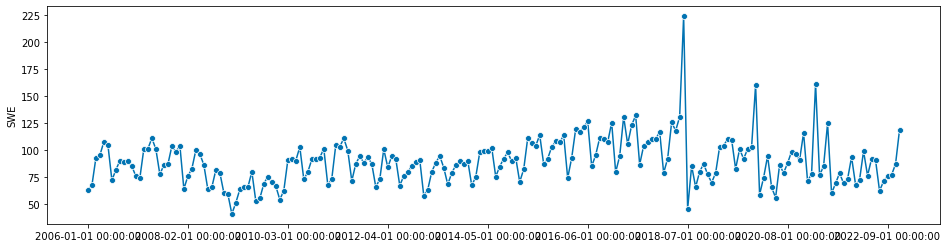

In [8]:
for column in df.columns[:]:
    x = df[column]
    plot_series(x)

In [9]:
title = country + ' countries betwwen 2006 and 2022'

fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=df.index, y=df.FIN, mode='lines', name='Finland')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df.DEN, mode='lines', name='Denmark')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df.NOR, mode='lines', name='Norway')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df.SWE, mode='lines', name='Sweden')))
fig.update_layout(height=500, width=1200, title=go.layout.Title(text=title),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date')),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Cars')))

fig.update_xaxes(rangeslider_visible=False)
fig.show()

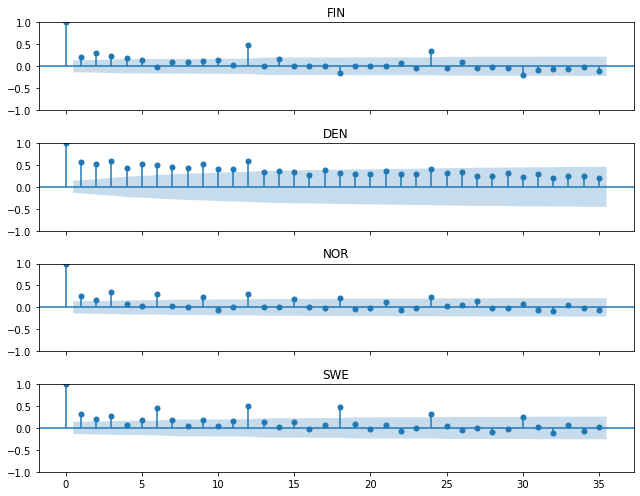

In [10]:
# Gráficos de autocorrelación
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(9, 7), sharex=True)
axes = axes.flat
for i, col in enumerate(df.columns[:4]):
    plot_acf(df[col], ax=axes[i], lags=7*5)
    axes[i].set_title(f'{col}')
fig.tight_layout()
plt.show()

### SKTIME

In [11]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_windows

In [12]:
df.index = pd.PeriodIndex(df.index, freq="M")

In [13]:
# Train/test split (12 months of test)
y_train, y_test = temporal_train_test_split(df[dep_var], test_size=12)  # This also determines the fh - so the intention here will be to predict next 12 months

fh = ForecastingHorizon(y_test.index, is_relative=False, freq='M')

# You could also manually set the FH - it should be the same as the test split but no necessarily
#fh = np.arange(1,13)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='FIN'>)

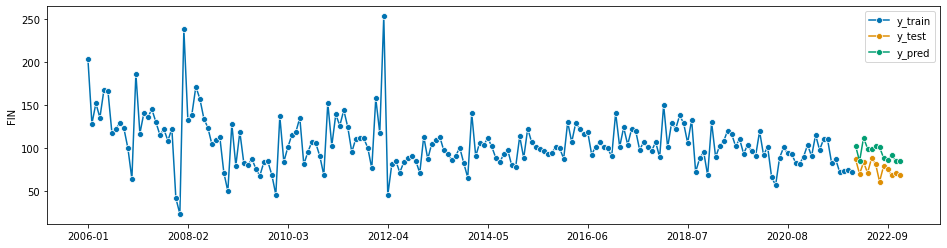

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, strategy="recursive", window_length=12) # window_length = lags
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

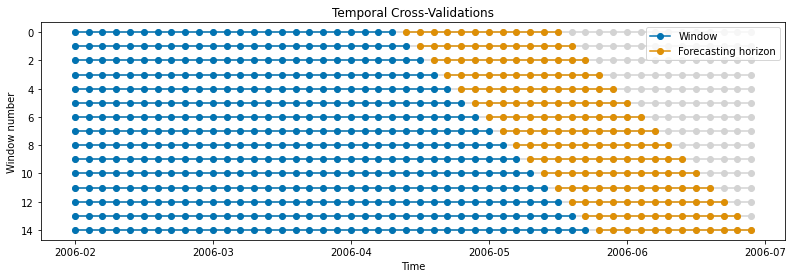

In [15]:
# Temporal Cross-Validation
cv = ExpandingWindowSplitter(step_length=1, initial_window=24, fh=fh.to_relative(cutoff=y_train.index.max()))
plot_windows(cv, df[dep_var].iloc[:50], "Temporal Cross-Validations")

In [20]:
print(df.shape, y_train.shape, y_test.shape)

(204, 4) (192,) (12,)


In [16]:
y_pred

2022-01    102.419614
2022-02     84.338213
2022-03    111.723137
2022-04     99.092989
2022-05     98.651890
2022-06    101.952784
2022-07    100.769167
2022-08     88.392652
2022-09     85.532857
2022-10     91.428886
2022-11     85.051324
2022-12     84.341889
Freq: M, dtype: float64

In [29]:
# Backtesting: Evaluation using temporal cross-validations
results = evaluate(
    forecaster=forecaster, y=df[dep_var], cv=cv, strategy="refit", return_data=True
)
results.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.214360,0.004655,0.010303,24,2007-12
1,0.218481,0.003248,0.007932,25,2008-01
2,0.286854,0.003814,0.008304,26,2008-02
3,0.298522,0.002973,0.007240,27,2008-03
4,0.365551,0.002919,0.007268,28,2008-04
...,...,...,...,...,...
164,0.331967,0.003316,0.008371,188,2021-08
165,0.315221,0.003627,0.007734,189,2021-09
166,0.269849,0.003621,0.006873,190,2021-10
167,0.256932,0.003776,0.007668,191,2021-11


In [35]:
results["y_pred"][2]

2008-03    128.470212
2008-04    124.077597
2008-05    124.889955
2008-06    120.126081
2008-07     92.877163
2008-08     95.045902
2008-09    105.904300
2008-10    122.893980
2008-11     98.964335
2008-12     91.770739
2009-01    189.551457
2009-02    126.349259
Freq: M, dtype: float64

matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


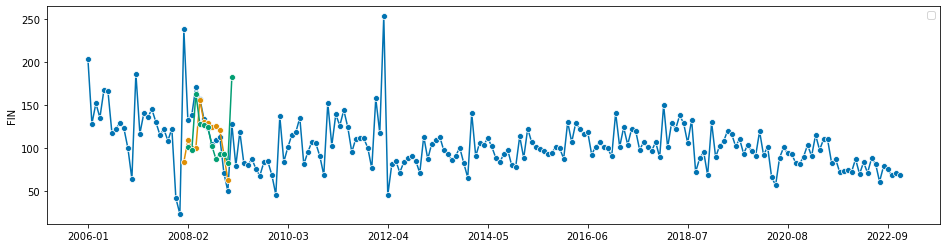

In [39]:
fig, ax = plot_series(
    df[dep_var],
    results["y_pred"].iloc[0],results["y_pred"].iloc[1],
    )
ax.legend();

### Split Data

In [18]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

print('\nData shape:', train.shape, test.shape)

Dataset length : (n=204)
Train dates    : 2006-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=168)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)

Data shape: (168, 4) (36, 4)


### Scoring function

In [19]:
metrics = pd.DataFrame()

def scoring(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(y_true, y_pred)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                          # RMSE (Root Mean Squared Error)
    r2 = r2_score(y_true, y_pred)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((y_true - y_pred) /y_true)) * 100        # MAPE
    accuracy = 100 - mape                                          # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy
        
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
        
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_true, mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions in " + country)    

        fig.show()  

### Models

In [20]:
# Dependant variable
dep_vars = ['FIN', 'DEN', 'NOR', 'SWE']

In [21]:

modelclasses = [
#    ["Extra Tree", ExtraTreesRegressor],
    ["XGBoost", XGBRegressor],
#    ["Gradient Boosting", GradientBoostingRegressor],
#    ["Random Forest", RandomForestRegressor],
#    ["Ada Boost", AdaBoostRegressor],
    ["LightGBM", LGBMRegressor],
#    ["Decision Tree", DecisionTreeRegressor]
]

for dep_var in dep_vars:
    number_of_lags = 12

    for model_name, Model in modelclasses:            

        # Create forecaster
        forecaster = ForecasterAutoregMultiVariate(
                    regressor          = Model(),
                    level              = dep_var,
                    lags               = number_of_lags,
                    steps              = steps,
                    transformer_series = StandardScaler(),
                    transformer_exog   = None,
                    weight_func        = None
                )
    
        # Fit model
        forecaster.fit(series=train)
        
        # Predict
        preds = forecaster.predict(steps=steps)

        # Score
        scoring(model_name + '_' + dep_var, test[dep_var], preds[dep_var], True, True)

XGBoost_FIN Model Performance:
Mean Absolute Error: 25.36.
Mean Squared Error: 918.45.
Root Mean Squared Error: 30.31.
R^2 Score = -2.98.
Mean Absolute Percentage Error: 32.52%.
Accuracy = 67.48%.


LightGBM_FIN Model Performance:
Mean Absolute Error: 25.89.
Mean Squared Error: 870.95.
Root Mean Squared Error: 29.51.
R^2 Score = -2.77.
Mean Absolute Percentage Error: 33.53%.
Accuracy = 66.47%.


XGBoost_DEN Model Performance:
Mean Absolute Error: 25.43.
Mean Squared Error: 947.59.
Root Mean Squared Error: 30.78.
R^2 Score = -1.21.
Mean Absolute Percentage Error: 34.20%.
Accuracy = 65.80%.


LightGBM_DEN Model Performance:
Mean Absolute Error: 24.68.
Mean Squared Error: 861.72.
Root Mean Squared Error: 29.36.
R^2 Score = -1.01.
Mean Absolute Percentage Error: 33.32%.
Accuracy = 66.68%.


XGBoost_NOR Model Performance:
Mean Absolute Error: 26.06.
Mean Squared Error: 1703.51.
Root Mean Squared Error: 41.27.
R^2 Score = -0.01.
Mean Absolute Percentage Error: 24.57%.
Accuracy = 75.43%.


LightGBM_NOR Model Performance:
Mean Absolute Error: 24.13.
Mean Squared Error: 1688.55.
Root Mean Squared Error: 41.09.
R^2 Score = 0.00.
Mean Absolute Percentage Error: 21.24%.
Accuracy = 78.76%.


XGBoost_SWE Model Performance:
Mean Absolute Error: 30.16.
Mean Squared Error: 1359.94.
Root Mean Squared Error: 36.88.
R^2 Score = -2.19.
Mean Absolute Percentage Error: 38.27%.
Accuracy = 61.73%.


LightGBM_SWE Model Performance:
Mean Absolute Error: 25.26.
Mean Squared Error: 831.87.
Root Mean Squared Error: 28.84.
R^2 Score = -0.95.
Mean Absolute Percentage Error: 33.06%.
Accuracy = 66.94%.


In [22]:
metrics

,XGBoost_FIN,LightGBM_FIN,XGBoost_DEN,LightGBM_DEN,XGBoost_NOR,LightGBM_NOR,XGBoost_SWE,LightGBM_SWE
Mean Absolute Error,25.363248,25.888790,25.429013,24.679483,26.063789,24.125349,30.156189,25.255846
Mean Squared Error,918.445819,870.951226,947.586752,861.717346,1703.512653,1688.552705,1359.941205,831.867103
Root Mean Squared Error,30.305871,29.511883,30.782897,29.355022,41.273631,41.092003,36.877381,28.842106
R^2,-2.975722,-2.770129,-1.208276,-1.008164,-0.008574,0.000283,-2.191312,-0.952104
Mean Absolute Percentage Error,32.519540,33.525249,34.202067,33.317247,24.571436,21.242388,38.270394,33.058203
Accuracy,67.480460,66.474751,65.797933,66.682753,75.428564,78.757612,61.729606,66.941797


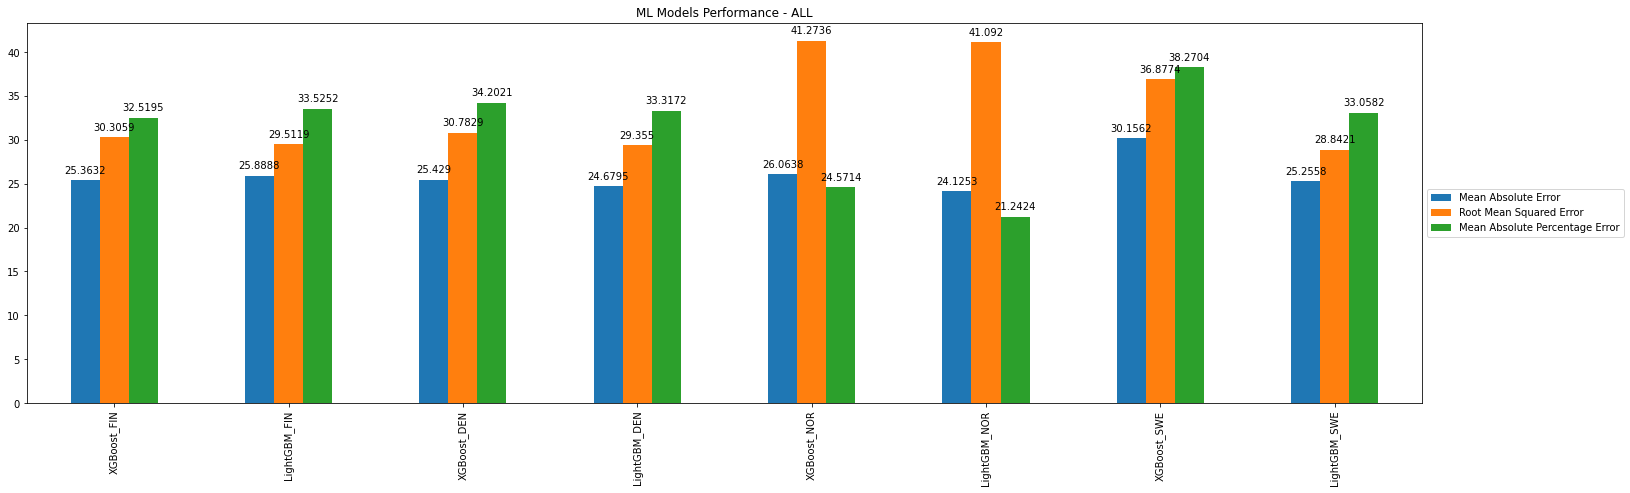

In [23]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="ML Models Performance - " + country, figsize=(25,7))
for container in ax.containers:
    ax.bar_label(container, padding=5)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))